<a href="https://colab.research.google.com/github/yasmws/English/blob/main/miniproject_02_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 34.4 MB/s 
     |████████████████████████████████| 1.3 MB 54.7 MB/s 
     |████████████████████████████████| 4.9 MB 48.1 MB/s 
     |████████████████████████████████| 432 kB 63.0 MB/s 
     |████████████████████████████████| 115 kB 51.5 MB/s 
     |████████████████████████████████| 163 kB 58.3 MB/s 
     |████████████████████████████████| 212 kB 66.6 MB/s 
     |████████████████████████████████| 127 kB 65.0 MB/s 
     |████████████████████████████████| 6.6 MB 61.1 MB/s 
Mounted at /content/gdrive


In [3]:
#hide
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

# clean
To download images with Bing Image Search, sign up at [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) for a free account. You will be given a key, which you can copy and enter in a cell as follows (replacing 'XXX' with your key and executing it):

In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '9253282967ac4620b6391f2717e32c98')

In [5]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [6]:
results = search_images_bing(key, 'pichu')
ims = results.attrgot('contentUrl')
len(ims)

150

In [7]:
#hide
ims = ['https://assets.pokemon.com/assets/cms2/img/pokedex/full/172.png']

In [8]:
dest = 'images/pichu.jpg'
download_url(ims[0], dest)

Path('images/pichu.jpg')

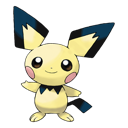

In [9]:
im = Image.open(dest)
im.to_thumb(128,128)

In [10]:
pokemon_types = 'pichu','pikachu','raichu'
path = Path('pokemon')

In [11]:
if not path.exists():
    path.mkdir()
    for o in pokemon_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} pokemon')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [12]:
fns = get_image_files(path)
fns

(#423) [Path('pokemon/pikachu/112e83c9-3a17-4243-8ca5-1d05e012fd28.jpg'),Path('pokemon/pikachu/31d37634-d298-463b-a1d9-897e2201f390.png'),Path('pokemon/pikachu/d1154def-fa41-4103-8389-73057b9d6ed8.jpg'),Path('pokemon/pikachu/5a7b9f6e-8b62-4a5b-a3a5-48b425580a28.png'),Path('pokemon/pikachu/a74c4401-1fac-4fb8-9dc8-b576ab7b6fad.jpg'),Path('pokemon/pikachu/7ac879f9-67a8-45a8-a0de-3f7cee2f87b2.jpg'),Path('pokemon/pikachu/e0d95c41-e83d-49fd-84f6-e685a2e50806.jpg'),Path('pokemon/pikachu/15c43072-1f9b-448d-8307-39417f13c99f.jpg'),Path('pokemon/pikachu/0413c3ed-0a57-484a-a12c-ac6b1464c804.jpg'),Path('pokemon/pikachu/4c916ab0-718a-4b19-9128-17deeffd279a.jpg')...]

In [13]:
failed = verify_images(fns)
failed

(#19) [Path('pokemon/pikachu/31d37634-d298-463b-a1d9-897e2201f390.png'),Path('pokemon/pikachu/13cd17c4-62ab-483d-acc1-5d7a993fb135.jpg'),Path('pokemon/pikachu/74dedd2b-2baa-42ee-a758-b97010461fed.jpg'),Path('pokemon/pikachu/30211f40-b49d-401c-88c7-37cbcc1f71a9.jpg'),Path('pokemon/pikachu/4010e671-1b59-418b-bed0-a142ebd50a1a.jpg'),Path('pokemon/pikachu/2032f3d3-f50d-46fa-b4cd-a37af556b219.jpg'),Path('pokemon/pikachu/57bff30d-0eb5-4915-b8e7-4d71aa3a7bb6.jpeg'),Path('pokemon/pikachu/d70c1ba4-f89c-41e0-a2a5-6b5c46477bfc.jpg'),Path('pokemon/raichu/ee2f7920-dc8f-4590-b546-e6c105c507bf.png'),Path('pokemon/raichu/276564e4-dcc9-4ff4-be15-a7025f151907.jpg')...]

In [14]:
failed.map(Path.unlink);

### Sidebar: Getting Help in Jupyter Notebooks

### End sidebar

## From Data to DataLoaders

In [15]:
pokemon = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [16]:
dls = pokemon.dataloaders(path)

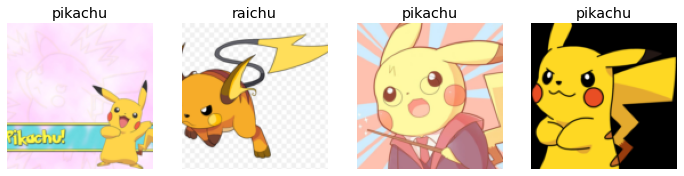

In [17]:
dls.valid.show_batch(max_n=4, nrows=1)

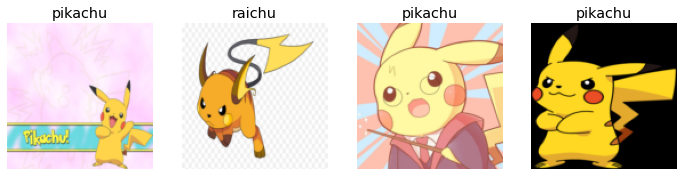

In [18]:
pokemon = pokemon.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = pokemon.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

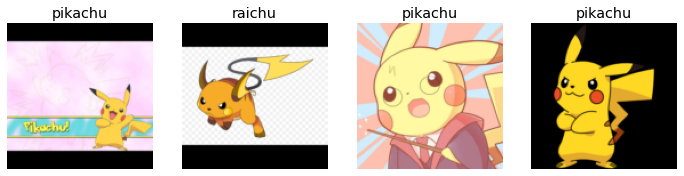

In [19]:
pokemon = pokemon.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = pokemon.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

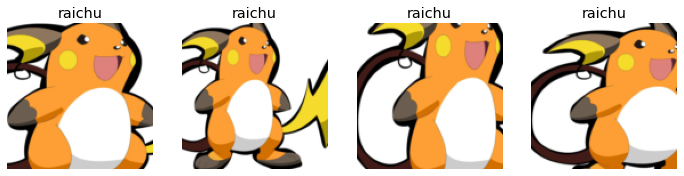

In [20]:
pokemon = pokemon.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = pokemon.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

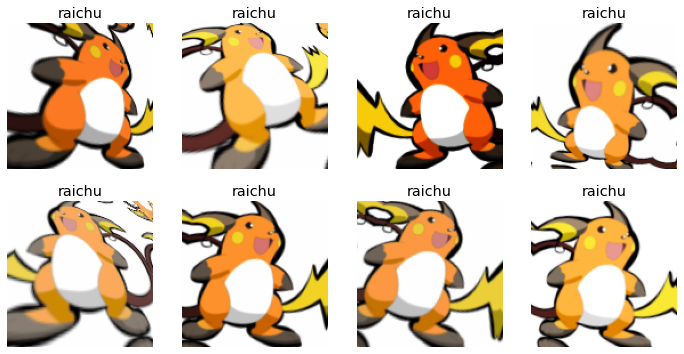

In [21]:
pokemon = pokemon.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = pokemon.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [22]:
pokemon = pokemon.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = pokemon.dataloaders(path)

In [23]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

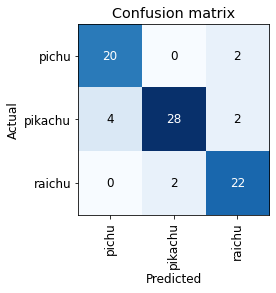

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

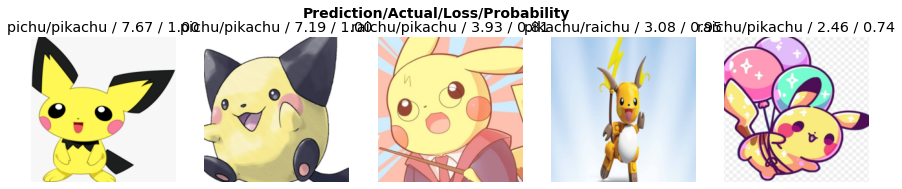

In [25]:
interp.plot_top_losses(5, nrows=1)

In [26]:
cleaner = ImageClassifierCleaner(learn)
cleaner

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [27]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [28]:
learn.export()

In [29]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [30]:
learn_inf = load_learner(path/'export.pkl')

In [36]:
learn_inf.predict('images/pichu.jpg')

('pichu', TensorBase(0), TensorBase([9.9991e-01, 8.7632e-06, 8.3985e-05]))

In [32]:
learn_inf.dls.vocab

['pichu', 'pikachu', 'raichu']

### Creating a Notebook App from the Model

In [44]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [45]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/pikachu.jpg'])

In [46]:
img = PILImage.create(btn_upload.data[-1])

In [47]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [48]:
pred,pred_idx,probs = learn_inf.predict(img)

In [49]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: pikachu; Probability: 0.9113')

In [50]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [51]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [52]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [53]:
VBox([widgets.Label('Select your pokemon!'), 
      btn_upload, btn_run, out_pl, lbl_pred])